In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import random
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetRegressor
%matplotlib inline

In [2]:
args = {
    'noise':0.01,
    'train size':0.7,
    'spec scale':10**12,
    'scaler':RobustScaler(),
    }

param_grid = {
    'module__num_hidden' : [2, 4, 6],
    'module__dropout_prob': [0.2, 0.5],
    'optimizer' : [torch.optim.Rprop],
    'optimizer__lr' : [0.01],
    'max_epochs' : [500, 1000, 5000]
}

In [3]:
df = pd.read_excel('data_3nm.xlsx')

In [4]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [5]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [6]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [7]:
# add noise
X_noisy = add_noise(X, args['noise'])

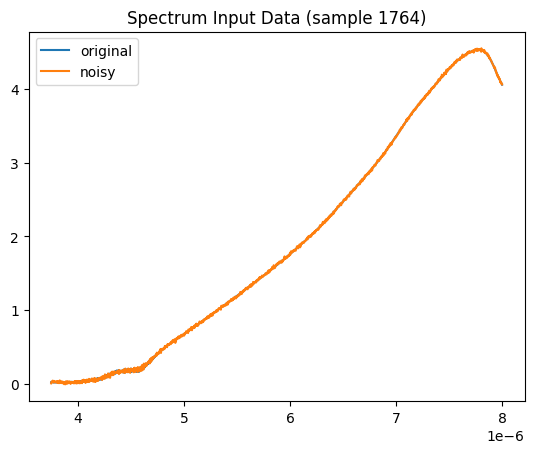

In [8]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [9]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [10]:
X_tensor = torch.tensor(X_noisy_scaled_df.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

In [11]:
class Net(nn.Module):
    def __init__(self, input_size, output_size, num_hidden, dropout_prob):
        super(Net, self).__init__()
        
        hidden_sizes = [input_size]
        step = input_size / (num_hidden+1)

        for i in range(num_hidden):
            hidden_size = int(input_size - (i+1) * step)
            if hidden_size < 1: hidden_size = 1
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.hidden_sizes = hidden_sizes
        self.dropout = nn.Dropout(dropout_prob)
        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x))
        x = self.dropout(x)
        x = self.lin_fin(x)
        return x

In [12]:
input_size = len(X.columns)
output_size = len(y.columns)

In [13]:
net = NeuralNetRegressor(
    module=Net,
    module__input_size=input_size,
    module__output_size=output_size,
    module__dropout_prob=0.2,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

gs = GridSearchCV(net, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

gs.fit(X_tensor, y_tensor)

best_model = gs.best_estimator_
best_params = gs.best_params_

print('Best loss: {}'.format(gs.best_score_))
print('Params: {}'.format(best_params))